<h1>光頭傑夫製作</h1><img src="https://rolqiw.bl.files.1drv.com/y4mYqkObWmQmdJFd8pab8t8m7d_mFhh3_YG63fiAnPaG6gjahHFt0n087pF97x1W2wemm7hd4ZdiPD2OxoPtqcCD_4-Jy-fojnt97kGGWR4Hnq0-9Ny61afd7WVHVTmF_9pcr45OFDFSwLKByeQU1q9TjwKk-HsNmWVsW1eGQ4Gi-9G4pQ5DYoTxswYJ5r5dLF-kKsA1InEyrqmV3kF5pm4WQ?width=658&height=584&cropmode=none" width=160px align="left" />

### <span style="color:red ">以下是我們需要的量化分析套件:
---    
    1. Jupyter Notebook環境中，第一次安裝過就好，以後直接導入模組就好。
    2. 如果你是在Colab的環境中運作檔案，請每次安裝

! pip install backtrader

### <span style="color:red ">以下是我們後續輸出分析結果需要的方程式:
---    
    1. 每次你要輸出策略的績效結果時，下面這格你都要跑

In [2]:
def printTradeAnalysis(analyzer):
    '''
    Function to print the Technical Analysis results in a nice format.
    '''
    #Get the results we are interested in
    total_closed = ''
    total_won =''
    total_lost =''
    win_streak = ''
    lose_streak = ''
    pnl_net =''
    strike_rate =''
    
    if len(analyzer.total)>2:
        total_closed = analyzer.total.closed
        total_won = analyzer.won.total
        total_lost = analyzer.lost.total
        win_streak = analyzer.streak.won.longest
        lose_streak = analyzer.streak.lost.longest
        pnl_net = round(analyzer.pnl.net.total,2)
    
    if total_closed:
        strike_rate=round((total_won / total_closed) * 100,2)
    else:
        strike_rate='沒有完整交易'
    print("策略運作分析結果:")
    print(f'獲利累積次數 : {str(total_won)}')
    print(f'損失累積次數 : {str(total_lost)}')
    print(f'獲利損失次數比 : {str(strike_rate)}')
    print(f'最高連續獲利交易次數 : {str(win_streak)}')
    print(f'最高連續損失交易次數 : {str(lose_streak)}')
    print(f'淨利結算 : {str(pnl_net)}')
    
    

## <span style="color:red ">  <策略1-with Commision>接下來，我們換個指標-布林通道(Bollinger Bands)，來做個簡單的回測策略吧!
---
### 先回想一下，你還記得布林通道是什麼意思嗎?
    
    以 20MA 為中心 上下各2個標準差 為範圍的軌道操作方式
    布林通道 又稱 布林格帶狀(Bollinger Bands，BBands) 或 保力加通道，
    是由 約翰．布林格(John Bollinger) 所提出的概念。
    
    

### <span style="color:red "><策略1.1- with Commision>導入需求模組

In [3]:
from datetime import datetime
import pandas as pd
import yfinance as yf
import backtrader as bt

### <span style="color:red "><策略1.2- with Commision>建立交易策略

In [19]:
class BbandsStrategy(bt.Strategy):
    #period是20MA的週期20天的意思
    #devfactor就是兩個標準差的意思
   
    params = dict(
        period=23,   
        devfactor=1.75,   
    )
 

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add an indicator
        self.boll = bt.indicators.BollingerBands(period=self.p.period, devfactor=self.p.devfactor)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'買單執行 --- 買價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'賣單執行 --- 賣價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失敗')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'運作結果 --- 獲利狀況: {trade.pnl:.2f}, 淨獲利: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] < self.boll.lines.bot:
                self.log(f'開出買單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.buy(size=1000)
        else:
            # sell condition
            if self.data_close[0]  > self.boll.lines.top:
                self.log(f'開出賣單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.sell(size=1000)

### <span style="color:red "><策略1.3- with Commision>抓取目標股票的歷史資料

In [14]:
data= yf.download(  '2330.tw',              #股票代碼
                    start='2022-3-30',      #資料開始日期
                    end='2023-3-30',         #資料結束日期
                    progress=False
                 )
print(data)
data=bt.feeds.PandasData(dataname=pd.DataFrame({'open': data['Open'], 
                   'high': data['High'],
                   'low': data['Low'],
                   'close': data['Close'],
                   'volume': data['Volume'],
                  }))

             Open   High    Low  Close   Adj Close    Volume
Date                                                        
2022-03-30  599.0  600.0  597.0  600.0  586.769043  41230239
2022-03-31  602.0  602.0  594.0  597.0  583.835205  22700114
2022-04-01  585.0  589.0  584.0  589.0  576.011597  29732696
2022-04-06  578.0  580.0  575.0  578.0  565.254150  37645873
2022-04-07  571.0  573.0  566.0  566.0  553.518799  42904743
...           ...    ...    ...    ...         ...       ...
2023-03-22  524.0  533.0  524.0  533.0  533.000000  42385987
2023-03-23  528.0  539.0  528.0  538.0  538.000000  26728246
2023-03-24  536.0  539.0  535.0  539.0  539.000000  21926240
2023-03-27  533.0  536.0  531.0  531.0  531.000000  16111177
2023-03-28  525.0  530.0  524.0  525.0  525.000000  17234120

[243 rows x 6 columns]


### <span style="color:red "><策略1.4- with Commision>建立台股交易費用計算模式

In [15]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)

### <span style="color:red "><策略1.5- with Commision>建立回測分析「大腦」

In [20]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000000

# create a Cerebro entity
cerebro = bt.Cerebro()

# set up the backtest
cerebro.adddata(data)
cerebro.addstrategy(BbandsStrategy)
cerebro.broker.setcash(cash)


#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=20
)

cerebro.broker.addcommissioninfo(comminfo)


### <span style="color:red "><策略1.6- with Commision>讓Analyzers來幫我診斷策略細節...-開始回測

In [21]:
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
strategies = cerebro.run()
firstStrat = strategies[0]

# print the analyzers
printTradeAnalysis(firstStrat.analyzers.ta.get_analysis())
print(f'持有資產總值: {cerebro.broker.getvalue():.2f}')

2022-05-09, 開出買單 --- 當時市場價格: 520.00
2022-05-10, 買單執行 --- 買價: 506.00, 成本: 506000.00, 手續費: 144.21
2022-05-30, 開出賣單 --- 當時市場價格: 547.00
2022-05-31, 賣單執行 --- 賣價: 542.00, 成本: 506000.00, 手續費: 1780.47
2022-05-31, 運作結果 --- 獲利狀況: 36000.00, 淨獲利: 34075.32
2022-06-17, 開出買單 --- 當時市場價格: 501.00
2022-06-20, 買單執行 --- 買價: 500.00, 成本: 500000.00, 手續費: 142.50
2022-08-15, 開出賣單 --- 當時市場價格: 523.00
2022-08-16, 賣單執行 --- 賣價: 526.00, 成本: 500000.00, 手續費: 1727.91
2022-08-16, 運作結果 --- 獲利狀況: 26000.00, 淨獲利: 24129.59
2022-09-01, 開出買單 --- 當時市場價格: 490.50
2022-09-02, 買單執行 --- 買價: 488.00, 成本: 488000.00, 手續費: 139.08
2022-11-11, 開出賣單 --- 當時市場價格: 441.50
2022-11-14, 賣單執行 --- 賣價: 450.00, 成本: 488000.00, 手續費: 1478.25
2022-11-14, 運作結果 --- 獲利狀況: -38000.00, 淨獲利: -39617.33
2022-12-19, 開出買單 --- 當時市場價格: 466.50
2022-12-20, 買單執行 --- 買價: 465.00, 成本: 465000.00, 手續費: 132.53
2023-01-10, 開出賣單 --- 當時市場價格: 486.00
2023-01-11, 賣單執行 --- 賣價: 487.00, 成本: 465000.00, 手續費: 1599.80
2023-01-11, 運作結果 --- 獲利狀況: 22000.00, 淨獲利: 20267.68
策略運作分析結果:
獲利累積次數 : 3
損

### <span style="color:red "><策略1.7- with Commision>畫張圖勝過千言萬語!-圖形化表達

<IPython.core.display.Javascript object>


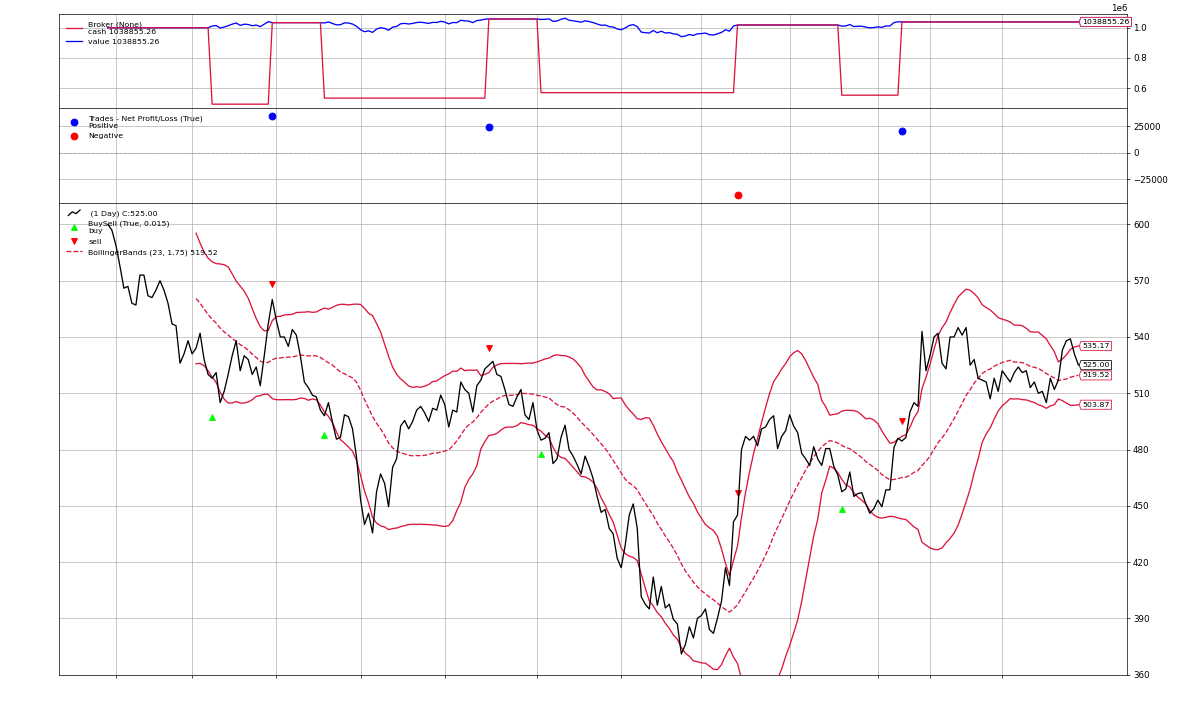

[[<Figure size 320x240 with 3 Axes>]]

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.rcParams['figure.dpi']=50
# plot results
cerebro.plot(iplot=True, volume=False)

### <span style="color:red "><策略2- with Commision>會不會是因為我們通道太寬，所以交易這麼佛系?
    
--------
    我想知道，如果我把通道做的窄一點，可不可以讓我的運作效率更好?

### <span style="color:red "><策略2.2- with Commision>建立交易策略

In [10]:
class BbandsStrategy(bt.Strategy):
    params = dict(
        period=20,   
        devfactor=1,   
    )
 

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add an indicator
        self.boll = bt.indicators.BollingerBands(period=self.p.period, devfactor=self.p.devfactor)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'買單執行 --- 買價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'賣單執行 --- 賣價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失敗')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'運作結果 --- 獲利狀況: {trade.pnl:.2f}, 淨獲利: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] < self.boll.lines.bot:
                self.log(f'開出買單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.buy(size=1000)
        else:
            # sell condition
            if self.data_close[0]  > self.boll.lines.top:
                self.log(f'開出賣單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.sell(size=1000)
    

### <span style="color:red "><策略2.4- with Commision>建立台股交易費用計算模式

In [11]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)

### <span style="color:red "><策略2.5- with Commision >建立回測分析「大腦」

In [12]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000000

# create a Cerebro entity
cerebro = bt.Cerebro()
cerebro.addstrategy(BbandsStrategy)
cerebro.adddata(data)
cerebro.broker.setcash(cash)


#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.5,
    tax=0.003,
    lowestfee=20
)

cerebro.broker.addcommissioninfo(comminfo)



### <span style="color:red "><策略2.6- with Commision>讓Analyzers來幫我診斷策略細節...-開始回測

In [13]:
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")

strategies = cerebro.run()
firstStrat = strategies[0]

# print the analyzers
printTradeAnalysis(firstStrat.analyzers.ta.get_analysis())
print(f'持有資產總值: {cerebro.broker.getvalue():.2f}')

2022-02-08, 開出買單 --- 當時市場價格: 628.00
2022-02-09, 買單執行 --- 買價: 635.00, 成本: 635000.00, 手續費: 452.44
2022-03-30, 開出賣單 --- 當時市場價格: 600.00
2022-03-31, 賣單執行 --- 賣價: 602.00, 成本: 635000.00, 手續費: 2234.93
2022-03-31, 運作結果 --- 獲利狀況: -33000.00, 淨獲利: -35687.36
2022-04-07, 開出買單 --- 當時市場價格: 566.00
2022-04-08, 買單執行 --- 買價: 567.00, 成本: 567000.00, 手續費: 403.99
2022-05-30, 開出賣單 --- 當時市場價格: 547.00
2022-05-31, 賣單執行 --- 賣價: 542.00, 成本: 567000.00, 手續費: 2012.17
2022-05-31, 運作結果 --- 獲利狀況: -25000.00, 淨獲利: -27416.16
2022-06-13, 開出買單 --- 當時市場價格: 516.00
2022-06-14, 買單執行 --- 買價: 507.00, 成本: 507000.00, 手續費: 361.24
2022-07-18, 開出賣單 --- 當時市場價格: 495.50
2022-07-19, 賣單執行 --- 賣價: 487.50, 成本: 507000.00, 手續費: 1809.84
2022-07-19, 運作結果 --- 獲利狀況: -19500.00, 淨獲利: -21671.08
2022-08-29, 開出買單 --- 當時市場價格: 498.50
2022-08-30, 買單執行 --- 買價: 497.50, 成本: 497500.00, 手續費: 354.47
2022-11-09, 開出賣單 --- 當時市場價格: 417.00
2022-11-10, 賣單執行 --- 賣價: 409.00, 成本: 497500.00, 手續費: 1518.41
2022-11-10, 運作結果 --- 獲利狀況: -88500.00, 淨獲利: -90372.88
2022-12-12, 開出買單

### <span style="color:red "><策略2.7- with Commision>畫張圖勝過千言萬語!-圖形化表達

<IPython.core.display.Javascript object>


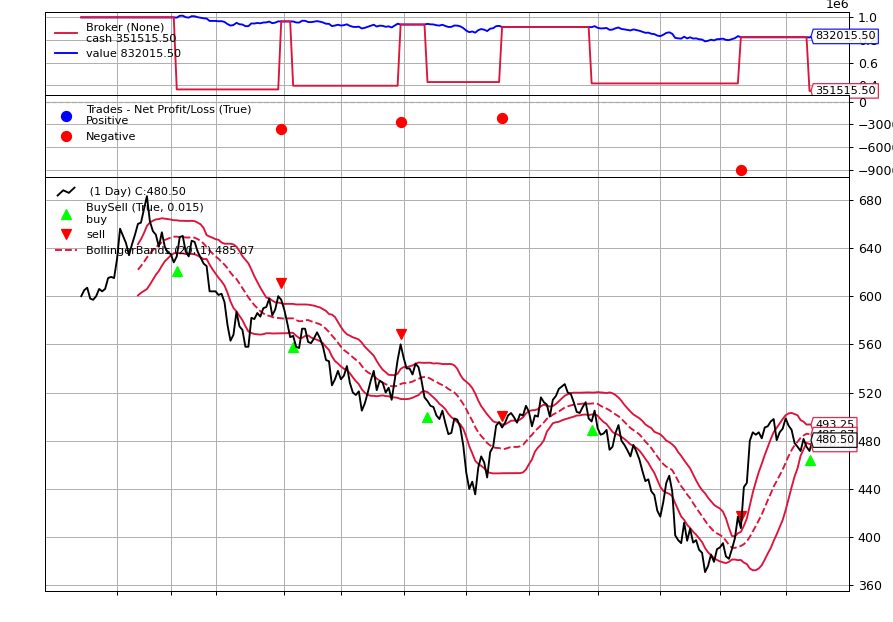

[[<Figure size 432x288 with 3 Axes>]]

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot results
cerebro.plot(iplot=True, volume=False)

### <span style="color:red "><策略3- with Commision>我知道布林通道的歷史定義，但是不就一條路嘛!我想看看這條換個設計方式，會不會好一點?
    
--------
    簡單的說，布林通道用20MA當基底，我想知道，換個中心線，可不可以讓我的運作效率更好?

### <span style="color:red "><策略3.2- with Commision>建立交易策略

In [10]:
class BbandsStrategy(bt.Strategy):
   
    params = dict(
        period=20,   
        devfactor=1,
    )

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add an indicator
        self.boll = bt.indicators.BollingerBands(period=self.p.period, devfactor=self.p.devfactor)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():              
                self.price = order.executed.price
                self.comm = order.executed.comm
            
                

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失敗')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] < self.boll.lines.bot:
                self.order = self.buy(size=1000)
        else:
            # sell condition
            if self.data_close[0]  > self.boll.lines.top:
                self.order = self.sell(size=1000)
    def stop(self):
        self.log(f'(MA週期設定 = {self.p.period:2d} devfactor設定={self.p.devfactor}) --- 淨利數值: {self.broker.getvalue()-cash:.2f}')
        self.params.totalValue=self.broker.getvalue()

### <span style="color:red "><策略3.4- with Commision>建立台股交易費用計算模式

In [11]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)

### <span style="color:red "><策略3.5- with Commision >建立回測分析「大腦」,讓Analyzers來幫我診斷策略細節...-開始回測

In [12]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000000

cerebro = bt.Cerebro()
cerebro.optstrategy(BbandsStrategy, period=range(3,60),devfactor=[1,1.25,1.5,1.75,2,2.25,2.5,2.75,3])
cerebro.adddata(data)
cerebro.broker.setcash(cash)


#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=20
)

cerebro.broker.addcommissioninfo(comminfo)

cerebro.addanalyzer(bt.analyzers.TradeAnalyzer,_name="ta")
opt_runs = cerebro.run(maxcpus=1)


for run in opt_runs:
    for strategy in run:
        print(f'布林通道計算週期設定:{strategy.params.period} 軌道寬度設定:{strategy.params.devfactor}')
        try:
            printTradeAnalysis(strategy.analyzers.ta.get_analysis())
        except KeyError :
            print('沒有交易發生')
        print(f'持有資產總值: {strategy.params.totalValue:.2f}')
        print('--------------------------------------------------------')



2023-03-28, (MA週期設定 =  3 devfactor設定=1) --- 淨利數值: -14110.73
2023-03-28, (MA週期設定 =  3 devfactor設定=1.25) --- 淨利數值: 14557.18
2023-03-28, (MA週期設定 =  3 devfactor設定=1.5) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 =  3 devfactor設定=1.75) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 =  3 devfactor設定=2) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 =  3 devfactor設定=2.25) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 =  3 devfactor設定=2.5) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 =  3 devfactor設定=2.75) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 =  3 devfactor設定=3) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 =  4 devfactor設定=1) --- 淨利數值: -24994.52
2023-03-28, (MA週期設定 =  4 devfactor設定=1.25) --- 淨利數值: 2934.72
2023-03-28, (MA週期設定 =  4 devfactor設定=1.5) --- 淨利數值: -102943.77
2023-03-28, (MA週期設定 =  4 devfactor設定=1.75) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 =  4 devfactor設定=2) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 =  4 devfactor設定=2.25) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 =  4 devfactor設定=2.5) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 =  4 devfactor設定=2.75) --- 淨利數值: 0.00
2023-03-28

2023-03-28, (MA週期設定 = 18 devfactor設定=1.5) --- 淨利數值: -59350.14
2023-03-28, (MA週期設定 = 18 devfactor設定=1.75) --- 淨利數值: 11169.95
2023-03-28, (MA週期設定 = 18 devfactor設定=2) --- 淨利數值: 35116.10
2023-03-28, (MA週期設定 = 18 devfactor設定=2.25) --- 淨利數值: -17427.62
2023-03-28, (MA週期設定 = 18 devfactor設定=2.5) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 = 18 devfactor設定=2.75) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 = 18 devfactor設定=3) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 = 19 devfactor設定=1) --- 淨利數值: -80775.94
2023-03-28, (MA週期設定 = 19 devfactor設定=1.25) --- 淨利數值: -58332.01
2023-03-28, (MA週期設定 = 19 devfactor設定=1.5) --- 淨利數值: -47364.57
2023-03-28, (MA週期設定 = 19 devfactor設定=1.75) --- 淨利數值: -17874.01
2023-03-28, (MA週期設定 = 19 devfactor設定=2) --- 淨利數值: 54938.36
2023-03-28, (MA週期設定 = 19 devfactor設定=2.25) --- 淨利數值: 23437.69
2023-03-28, (MA週期設定 = 19 devfactor設定=2.5) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 = 19 devfactor設定=2.75) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 = 19 devfactor設定=3) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 = 20 devfactor設定=1) --- 淨

2023-03-28, (MA週期設定 = 33 devfactor設定=2) --- 淨利數值: 47460.60
2023-03-28, (MA週期設定 = 33 devfactor設定=2.25) --- 淨利數值: 46759.17
2023-03-28, (MA週期設定 = 33 devfactor設定=2.5) --- 淨利數值: 46759.17
2023-03-28, (MA週期設定 = 33 devfactor設定=2.75) --- 淨利數值: 40257.31
2023-03-28, (MA週期設定 = 33 devfactor設定=3) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 = 34 devfactor設定=1) --- 淨利數值: 59923.30
2023-03-28, (MA週期設定 = 34 devfactor設定=1.25) --- 淨利數值: 22861.41
2023-03-28, (MA週期設定 = 34 devfactor設定=1.5) --- 淨利數值: 8536.95
2023-03-28, (MA週期設定 = 34 devfactor設定=1.75) --- 淨利數值: 38951.04
2023-03-28, (MA週期設定 = 34 devfactor設定=2) --- 淨利數值: 245.91
2023-03-28, (MA週期設定 = 34 devfactor設定=2.25) --- 淨利數值: 46759.17
2023-03-28, (MA週期設定 = 34 devfactor設定=2.5) --- 淨利數值: 46759.17
2023-03-28, (MA週期設定 = 34 devfactor設定=2.75) --- 淨利數值: 40257.31
2023-03-28, (MA週期設定 = 34 devfactor設定=3) --- 淨利數值: 0.00
2023-03-28, (MA週期設定 = 35 devfactor設定=1) --- 淨利數值: 61923.88
2023-03-28, (MA週期設定 = 35 devfactor設定=1.25) --- 淨利數值: 11858.27
2023-03-28, (MA週期設定 = 35 devfactor設定=1.5

2023-03-28, (MA週期設定 = 48 devfactor設定=2.25) --- 淨利數值: 45596.45
2023-03-28, (MA週期設定 = 48 devfactor設定=2.5) --- 淨利數值: 92109.70
2023-03-28, (MA週期設定 = 48 devfactor設定=2.75) --- 淨利數值: 92109.70
2023-03-28, (MA週期設定 = 48 devfactor設定=3) --- 淨利數值: 92109.70
2023-03-28, (MA週期設定 = 49 devfactor設定=1) --- 淨利數值: 36378.92
2023-03-28, (MA週期設定 = 49 devfactor設定=1.25) --- 淨利數值: 32885.07
2023-03-28, (MA週期設定 = 49 devfactor設定=1.5) --- 淨利數值: -34231.79
2023-03-28, (MA週期設定 = 49 devfactor設定=1.75) --- 淨利數值: -7765.29
2023-03-28, (MA週期設定 = 49 devfactor設定=2) --- 淨利數值: 45596.45
2023-03-28, (MA週期設定 = 49 devfactor設定=2.25) --- 淨利數值: 63601.58
2023-03-28, (MA週期設定 = 49 devfactor設定=2.5) --- 淨利數值: 92109.70
2023-03-28, (MA週期設定 = 49 devfactor設定=2.75) --- 淨利數值: 92109.70
2023-03-28, (MA週期設定 = 49 devfactor設定=3) --- 淨利數值: 92109.70
2023-03-28, (MA週期設定 = 50 devfactor設定=1) --- 淨利數值: 36378.92
2023-03-28, (MA週期設定 = 50 devfactor設定=1.25) --- 淨利數值: 31884.78
2023-03-28, (MA週期設定 = 50 devfactor設定=1.5) --- 淨利數值: -34231.79
2023-03-28, (MA週期設定 = 50 